In [15]:
import transformers
import pandas as pd
import torch
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tqdm.auto import tqdm
from sklearn.metrics import f1_score, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel

In [2]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
LM1 = AutoModelForSequenceClassification.from_pretrained('jihoonkimharu/bert-base-klue-ynat-finetuned').to(DEVICE)
LM2 = AutoModelForSequenceClassification.from_pretrained('yobi/klue-roberta-base-ynat').to(DEVICE)
LM3 = AutoModelForSequenceClassification.from_pretrained('ehddnr301/bert-base-ehddnr-ynat').to(DEVICE)
LM4 = AutoModelForSequenceClassification.from_pretrained('bash1130/bert-base-finetuned-ynat').to(DEVICE)

In [4]:
tokenizer1 = AutoTokenizer.from_pretrained('jihoonkimharu/bert-base-klue-ynat-finetuned')
tokenizer2 = AutoTokenizer.from_pretrained('yobi/klue-roberta-base-ynat')
tokenizer3 = AutoTokenizer.from_pretrained('ehddnr301/bert-base-ehddnr-ynat')
tokenizer4 = AutoTokenizer.from_pretrained('bash1130/bert-base-finetuned-ynat')

In [5]:
train_df = pd.read_csv('../data/train_spelling_v2.csv')

In [6]:
train_df.columns

Index(['ID', 'text', 'target', 'url', 'date'], dtype='object')

In [17]:
def inference(model1, model2, model3, model4, data, tokenizer1, tokenizer2, tokenizer3, tokenizer4, DEVICE):
    model1.eval()
    model2.eval()
    model3.eval()
    model4.eval()
    preds = []
    
    for idx, sample in tqdm(data.iterrows()):
        inputs1 = tokenizer1(sample['text'], return_tensors="pt").to(DEVICE)
        inputs2 = tokenizer2(sample['text'], return_tensors="pt").to(DEVICE)
        inputs3 = tokenizer3(sample['text'], return_tensors="pt").to(DEVICE)
        inputs4 = tokenizer4(sample['text'], return_tensors="pt").to(DEVICE)
        
        with torch.no_grad():
            logits1 = model1(**inputs1).logits
            logits2 = model2(**inputs2).logits
            logits3 = model3(**inputs3).logits
            logits4 = model4(**inputs4).logits
            logits = logits1 + logits2 + logits3 + logits4
            pred = torch.argmax(torch.nn.Softmax(dim=1)(logits), dim=1).cpu().numpy()
            preds.extend(pred)

        if not idx % 500:
            print(idx, ' / ', len(data))

    return preds

In [10]:
tokenizer1('안녕하세요 저는 누구일까요')

{'input_ids': [2, 5891, 2205, 5971, 1535, 2259, 4061, 2210, 6301, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [11]:
LM1(**tokenizer1('아 제발 좀', return_tensors='pt').to(DEVICE), output_hidden_states=True).hidden_states[0].size()

torch.Size([1, 5, 768])

In [18]:
pred = inference(LM1, LM2, LM3, LM4, train_df, tokenizer1, tokenizer2, tokenizer3, tokenizer4, DEVICE)

train_df['pred'] = pred
train_df.to_csv("../data/predaddLM_train_spelling_v2.csv", index=False)

0it [00:00, ?it/s]

0  /  45678
500  /  45678
1000  /  45678
1500  /  45678
2000  /  45678
2500  /  45678
3000  /  45678
3500  /  45678
4000  /  45678
4500  /  45678
5000  /  45678
5500  /  45678
6000  /  45678
6500  /  45678
7000  /  45678
7500  /  45678
8000  /  45678
8500  /  45678
9000  /  45678
9500  /  45678
10000  /  45678
10500  /  45678
11000  /  45678
11500  /  45678
12000  /  45678
12500  /  45678
13000  /  45678
13500  /  45678
14000  /  45678
14500  /  45678
15000  /  45678
15500  /  45678
16000  /  45678
16500  /  45678
17000  /  45678
17500  /  45678
18000  /  45678
18500  /  45678
19000  /  45678
19500  /  45678
20000  /  45678
20500  /  45678
21000  /  45678
21500  /  45678
22000  /  45678
22500  /  45678
23000  /  45678
23500  /  45678
24000  /  45678
24500  /  45678
25000  /  45678
25500  /  45678
26000  /  45678
26500  /  45678
27000  /  45678
27500  /  45678
28000  /  45678
28500  /  45678
29000  /  45678
29500  /  45678
30000  /  45678
30500  /  45678
31000  /  45678
31500  /  45678


In [19]:
label2num = {'IT과학':0,
             '경제':1,
             '사회':2,
             '생활문화':3,
             '세계':4,
             '스포츠':5,
             '정치':6}

In [20]:
train_df['compare'] = train_df['pred'].apply(lambda x:str(x)) + train_df['target'].apply(lambda x:str(x))

In [21]:
train_df['compare'].value_counts()

compare
44    7850
55    7463
66    7022
11    5596
33    5424
00    4939
22    4347
01     249
62     190
02     170
32     163
12     136
46     122
54     119
23     100
20      99
10      96
42      95
64      88
52      79
21      78
41      76
26      72
03      69
04      62
45      55
56      54
53      52
34      51
14      48
40      48
51      47
30      47
16      43
13      43
61      42
43      42
05      41
50      41
65      40
60      39
35      34
15      32
24      32
31      31
36      30
63      30
06      29
25      23
Name: count, dtype: int64

In [22]:
confusion_matrix(y_true = train_df['pred'], y_pred = train_df['target'])

array([[4939,  249,  170,   69,   62,   41,   29],
       [  96, 5596,  136,   43,   48,   32,   43],
       [  99,   78, 4347,  100,   32,   23,   72],
       [  47,   31,  163, 5424,   51,   34,   30],
       [  48,   76,   95,   42, 7850,   55,  122],
       [  41,   47,   79,   52,  119, 7463,   54],
       [  39,   42,  190,   30,   88,   40, 7022]])

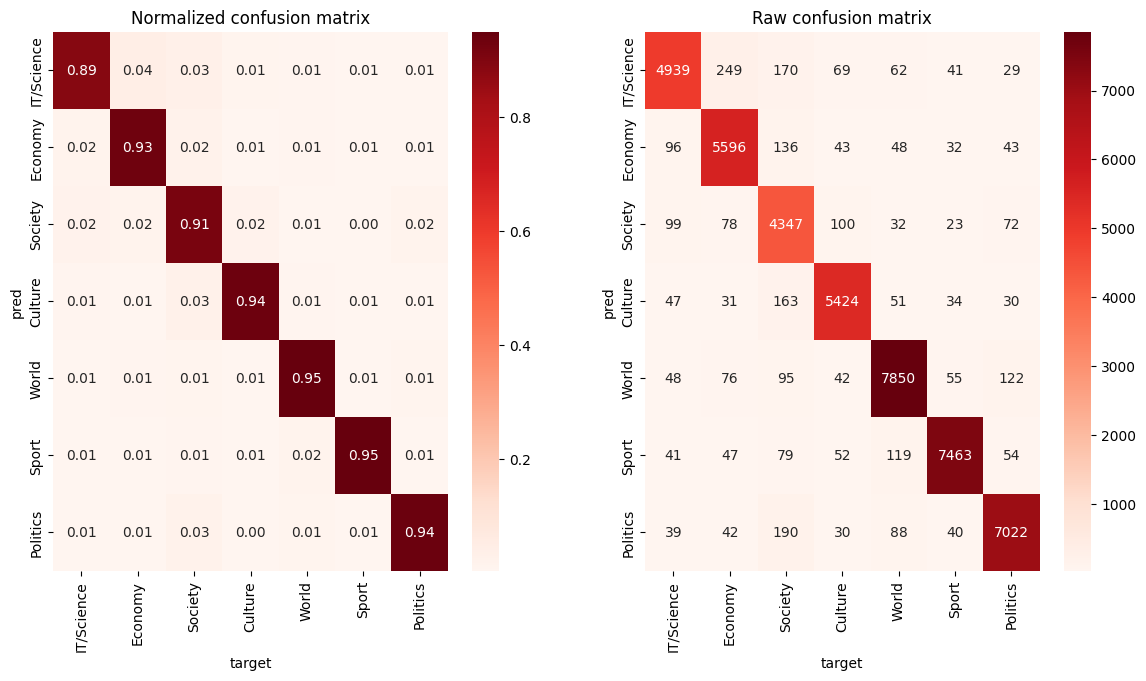

In [23]:
cm = confusion_matrix(y_true = train_df['pred'], y_pred = train_df['target'])

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))


sns.heatmap(cmn, cmap='Reds', annot=True, fmt='.2f', xticklabels=['IT/Science', 'Economy', 'Society', 'Culture', 'World', 'Sport', 'Politics'], 
            yticklabels=['IT/Science', 'Economy', 'Society', 'Culture', 'World', 'Sport', 'Politics'], ax=ax1)
ax1.set_ylabel('pred')
ax1.set_xlabel('target')
ax1.set_title('Normalized confusion matrix')


sns.heatmap(cm, cmap='Reds', annot=True, fmt='d', xticklabels=['IT/Science', 'Economy', 'Society', 'Culture', 'World', 'Sport', 'Politics'], 
            yticklabels=['IT/Science', 'Economy', 'Society', 'Culture', 'World', 'Sport', 'Politics'], ax=ax2)
ax2.set_ylabel('pred')
ax2.set_xlabel('target')
ax2.set_title('Raw confusion matrix')

plt.show(block=False)

In [25]:
train_df['pred'].value_counts()

pred
4    8288
5    7855
6    7451
1    5994
3    5780
0    5559
2    4751
Name: count, dtype: int64

In [28]:
train_df[train_df['pred'] == 5]

,ID,text,target,url,date,pred,compare
6,ynat-v1_train_00006,월드컵 태극전사 16강 전초기지 레오강 입성종합,5,https://sports.news.naver.com/news.nhn?oid=001...,2018.06.04 08:15,5,55
13,ynat-v1_train_00013,황재균 쐐기타…kt 갈 길 바쁜 삼성에 고춧가루,5,https://sports.news.naver.com/news.nhn?oid=001...,2018.09.16 17:28,5,55
28,ynat-v1_train_00028,손흥민 더 승부욕 갖고 거칠게 해야…나부터 반성,5,https://sports.news.naver.com/news.nhn?oid=001...,2018.06.02 00:19,5,55
33,ynat-v1_train_00033,다시 포효한 황의조 3년 만의 A매치 골 집중력 유지한...,5,https://sports.news.naver.com/news.nhn?oid=001...,2018.10.12 23:40,5,55
36,ynat-v1_train_00036,프리미어12 보러 온 MLB 최지만 저도 뛰고 싶었지만,5,https://sports.news.naver.com/news.nhn?oid=001...,2019.11.08 20:50,5,55
...,...,...,...,...,...,...,...
45659,ynat-v1_train_45659,강정호 25일 마이애미전 5번타자 3루수 선발 출전,5,https://sports.news.naver.com/news.nhn?oid=001...,2019.02.24 22:55,5,55
45663,ynat-v1_train_45663,FA 최대어 정지석·문성민·양효진 원소속팀 잔류로 가닥,5,https://sports.news.naver.com/news.nhn?oid=001...,2019.04.01 11:14,5,55
45674,ynat-v1_train_45674,박기원 감독 눈치 보지 말고…비예나 눈치 본 건 아닌데,5,https://sports.news.naver.com/news.nhn?oid=001...,2019.11.03 17:06,5,55
45675,ynat-v1_train_45675,아시안게임 첫 경기 앞둔 라건아 인도네시아 팬이라도 ...,5,https://sports.news.naver.com/news.nhn?oid=001...,2018.08.13 17:54,5,55


In [30]:
v1.columns

Index(['ID', 'text', 'url', 'date', 'pred'], dtype='object')

In [33]:
v1 = train_df.drop(['target', 'compare', 'url', 'date'], axis = 1)
v1.columns = ['ID', 'text', 'target']
v1.to_csv('../data/train_spelling_v2_labeladdLM_v1.csv',index=False)

In [34]:
v2 = train_df[train_df['target'] == train_df['pred']].drop(['pred', 'compare', 'url', 'date'], axis = 1)
v2.to_csv('../data/train_spelling_v2_labeladdLM_v2.csv',index=False)

In [25]:
print(v1['target'].value_counts())
print(train_df['pred'].value_counts())

target
2    40415
1    18544
5    17849
3    17599
6    16296
4    13824
0     7747
Name: count, dtype: int64
pred
2    40415
1    18544
5    17849
3    17599
6    16296
4    13824
0     7747
Name: count, dtype: int64


In [26]:
v2['target'].value_counts()

target
2    17044
5    16645
1    15566
6    11775
3    11754
4     8949
0     4783
Name: count, dtype: int64

In [27]:
IT1 = pd.read_csv('../data/AG1718IT.csv')[['제목', '통합 분류1']].rename(columns={'제목': 'text', '통합 분류1': 'label_text'})
IT2 = pd.read_csv('../data/FN1718IT.csv')[['제목', '통합 분류1']].rename(columns={'제목': 'text', '통합 분류1': 'label_text'})
IT3 = pd.read_csv('../data/FN1920IT.csv')[['제목', '통합 분류1']].rename(columns={'제목': 'text', '통합 분류1': 'label_text'})
IT = pd.concat([IT1, IT2, IT3], axis = 0)
print(len(IT1))
print(len(IT2))
print(len(IT3))
print(len(IT))

20000
20000
13871
53871


In [28]:
IT['label_text'] = IT['label_text'].apply(lambda x: x.split('>')[0])
IT = IT[IT['label_text'] == 'IT_과학']
IT['target'] = 0

In [29]:
IT.head(5)

,text,label_text,target
0,'180억 기부했는데 세금폭탄' 황필상 박사 별세,IT_과학,0
3,범블비 개봉 첫주 105만 돌파...“로봇에게도 필요한 윤리 기준이 있다고?”,IT_과학,0
4,[카드뉴스] 2018년 가장 많이 검색한 구글 검색어 (BEST KEYWORD-게임편),IT_과학,0
7,"[신년사] 이병래 예탁원 사장 ""전자증권제도 성공해야""",IT_과학,0
9,새해부터 빅데이터가 스마트폰 요금제 추천해준다,IT_과학,0


In [30]:
len(IT)

34845

In [33]:
pred_IT = inference(LM1, LM2, LM3, LM4, IT, tokenizer1, tokenizer2, tokenizer3, tokenizer4, DEVICE)

IT['pred'] = pred_IT
IT.to_csv("../data/IT_augmented_addLM.csv", index=False)

0  /  34845
500  /  34845
1500  /  34845
2000  /  34845
2500  /  34845
4000  /  34845
4500  /  34845
5500  /  34845
6000  /  34845
7000  /  34845
8000  /  34845
8500  /  34845
9000  /  34845
9500  /  34845
10000  /  34845
10500  /  34845
11000  /  34845
12000  /  34845
13000  /  34845
14000  /  34845
14500  /  34845
15000  /  34845
16000  /  34845
16500  /  34845
17000  /  34845
18000  /  34845
18500  /  34845
19000  /  34845
19500  /  34845
500  /  34845
1500  /  34845
2500  /  34845
3000  /  34845
3500  /  34845
4000  /  34845
4500  /  34845
5000  /  34845
5500  /  34845
6500  /  34845
7000  /  34845
8000  /  34845
8500  /  34845
9500  /  34845
10000  /  34845
11000  /  34845
11500  /  34845
12000  /  34845
13000  /  34845
14000  /  34845
14500  /  34845
15500  /  34845
16000  /  34845
16500  /  34845
17000  /  34845
19000  /  34845
19500  /  34845
1000  /  34845
1500  /  34845
2000  /  34845
2500  /  34845
3000  /  34845
4000  /  34845
4500  /  34845
5000  /  34845
6500  /  34845
75

In [34]:
IT['pred'].value_counts()

pred
0    16495
1     7418
2     7414
3     2078
4      761
6      540
5      139
Name: count, dtype: int64

In [35]:
IT_labeled = IT[IT['pred'] == 0]

In [36]:
IT_labeled['pred'].value_counts()

pred
0    16495
Name: count, dtype: int64

In [37]:
print(IT_labeled['target'].value_counts())
IT_labeled.drop(['pred'], axis = 1, inplace=True)
IT_labeled.columns

target
0    16495
Name: count, dtype: int64


/tmp/ipykernel_10254/1986709349.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IT_labeled.drop(['pred'], axis = 1, inplace=True)


Index(['text', 'label_text', 'target'], dtype='object')

In [38]:
v1_augIT = pd.concat([v1, IT_labeled], axis = 0)
v1_augIT.to_csv('../data/cleaned_2020_labeladdLM_v1_augIT.csv', index=False)

In [39]:
v2_augIT = pd.concat([v2, IT_labeled], axis = 0)
v2_augIT.to_csv('../data/cleaned_2020_labeladdLM_v2_augIT.csv', index=False)

In [40]:
print(v1_augIT['target'].value_counts())
print(v1['target'].value_counts())

target
2    40415
0    24242
1    18544
5    17849
3    17599
6    16296
4    13824
Name: count, dtype: int64
target
2    40415
1    18544
5    17849
3    17599
6    16296
4    13824
0     7747
Name: count, dtype: int64


In [41]:
print(v2_augIT['target'].value_counts())
print(v2['target'].value_counts())

target
0    21278
2    17044
5    16645
1    15566
6    11775
3    11754
4     8949
Name: count, dtype: int64
target
2    17044
5    16645
1    15566
6    11775
3    11754
4     8949
0     4783
Name: count, dtype: int64


--------------
